In [1]:
import pickle
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2024-04-03 00:49:41.921261: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-04-03 00:49:41.968043: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-03 00:49:42.577890: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# Model Definition
P3 = 128
# Modality Specific Module
class ModalitySpecificModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)  
    # Text MSM Layers
    self.bigru_text = keras.layers.Bidirectional(keras.layers.GRU(256))
    self.msl_1_text = keras.layers.Dense(128, activation='relu')
    self.msl_2_text = keras.layers.Dense(P3, activation='relu')
    # Audio MSM Layers
    self.bigru_audio = keras.layers.Bidirectional(keras.layers.GRU(256))
    self.msl_1_audio = keras.layers.Dense(128, activation='relu')
    self.msl_2_audio = keras.layers.Dense(P3, activation='relu')
    # Visual MSM Layers
    self.bigru_visual = keras.layers.Bidirectional(keras.layers.GRU(256))
    self.msl_1_visual = keras.layers.Dense(128, activation='relu')
    self.msl_2_visual = keras.layers.Dense(P3, activation='relu')

  def __call__(self, text_input, audio_input, visual_input):
    # Text MSM
    bigru_text_output = self.bigru_text(text_input)
    msl_l1_text = self.msl_1_text(bigru_text_output)
    text_msm_output = self.msl_2_text(msl_l1_text)
    # Audio MSM
    bigru_audio_output = self.bigru_audio(audio_input)
    msl_l1_audio = self.msl_1_audio(bigru_audio_output)
    audio_msm_output = self.msl_2_audio(msl_l1_audio)
    # Visual MSM
    bigru_visual_output = self.bigru_visual(visual_input)
    msl_l1_visual = self.msl_1_visual(bigru_visual_output)
    visual_msm_output = self.msl_2_visual(msl_l1_visual)

    return text_msm_output, audio_msm_output, visual_msm_output


# Dense Multimodal Fusion Module
class DenseMultimodalFusionModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.residual_features = []

  def df_wrapper(self, f1, f2, f3, n):
    for i in range(n):
      f1, f2, f3 = self.df_layer(f1, f2, f3)
    r = keras.layers.Add()([f1, f2, f3])
    self.residual_features.append(r)
    return self.residual_features

  # df layer
  def df_layer(self, f1, f2, f3):
    r = keras.layers.Add()([f1, f2, f3])
    self.residual_features.append(r)
    # concatenation before feeding to df block
    df_input1 = keras.layers.Concatenate()([f1, f3])
    df_input2 = keras.layers.Concatenate()([f1, f2])
    df_input3 = keras.layers.Concatenate()([f2, f3])
    # df block
    df_output1 = keras.layers.Dense(P3, activation='relu')(df_input1)
    df_output2 = keras.layers.Dense(P3, activation='relu')(df_input2)
    df_output3 = keras.layers.Dense(P3, activation='relu')(df_input3)

    return df_output1, df_output2, df_output3

  def __call__(self, f1_0, f2_0, f3_0):
    DF_LAYER_COUNT = 16
    residual = self.df_wrapper(f1_0, f2_0, f3_0, DF_LAYER_COUNT)
    return residual


# Multimodal Residual Module
class MultimodalResidualModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)

  def __call__(self, residual_features):
    final_residual_feature = keras.layers.Add()(residual_features)
    return final_residual_feature


# Sentiment Classification Module
class SentimentClassificationModule(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.layer_1 = keras.layers.Dense(128, activation='relu')
    self.layer_2 = keras.layers.Dense(64, activation='relu')
    self.layer_3 = keras.layers.Dense(32, activation='relu')
    self.layer_4 = keras.layers.Dense(16, activation='relu')
    num_classes = 7
    self.classification_layer = keras.layers.Dense(num_classes, activation='softmax')

  def __call__(self, residual_feature):
    output_l1 = self.layer_1(residual_feature)
    output_l2 = self.layer_2(output_l1)
    output_l3 = self.layer_3(output_l2)
    output_l4 = self.layer_4(output_l3)
    sentiment = self.classification_layer(output_l4)
    return sentiment

# deep dense fusion network with multimodal residual (DFMR)
class DFMR(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    self.text_input = keras.Input(shape=(50, 300))
    self.audio_input = keras.Input(shape=(50, 5))
    self.visual_input = keras.Input(shape=(50, 20))

    # Major Modules of DFMR
    self.msm = ModalitySpecificModule()
    self.dmfm = DenseMultimodalFusionModule()
    self.mrm = MultimodalResidualModule()
    self.scm = SentimentClassificationModule()

  def __call__(self):
    # major module structure overview
    text_msm_output, audio_msm_output, visual_msm_output = self.msm(self.text_input, self.audio_input, self.visual_input)
    residual_features = self.dmfm(text_msm_output, audio_msm_output, visual_msm_output)
    final_residual_feature = self.mrm(residual_features)
    output = self.scm(final_residual_feature)    
    # model definition
    model = keras.Model(inputs=[self.text_input, self.audio_input, self.visual_input], outputs=output)
    return model


dfmr_model = DFMR()
model = dfmr_model()
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 50, 300)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 50, 5)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 50, 20)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 512)       │    857,088 │ input_layer[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 512)       │    403,968 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 512)       │    427,008 │ input_layer_2[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     65,664 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 128)       │     65,664 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 128)       │     65,664 │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,512 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     16,512 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 128)       │     16,512 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, 256)       │          0 │ dense_1[0][0],    │
│ (Concatenate)       │                   │            │ dense_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 256)       │          0 │ dense_3[0][0],    │
│ (Concatenate)       │                   │            │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_12 (Dense)    │ (None, 128)       │     32,896 │ concatenate_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, 128)       │     32,896 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 256)       │          0 │ dense_11[0][0],   │
│ (Concatenate)       │                   │            │ dense_13[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 256)       │          0 │ dense_11[0][0], 

 Total params: 3,541,095 (13.51 MB)

 Trainable params: 3,541,095 (13.51 MB)

 Non-trainable params: 0 (0.00 B)

In [3]:
model.compile(
  optimizer='adam',
  loss=keras.losses.MeanAbsoluteError(),
  metrics=[
    keras.metrics.Accuracy()
  ]
)

In [2]:
# with open('/content/drive/MyDrive/Colab Notebooks/Multimodal Sentiment Analysis/mosi_data.pkl', 'rb') as fp:
#   data = pickle.load(fp)

with open('../../datasets/MOSI/mosi_data.pkl', 'rb') as fp:
  data = pickle.load(fp)

In [3]:
def convertLabels(label):
  result = 0
  if label < -2:
    result = -3
  elif -2 <= label and label < -1:
    result = -2
  elif -1 <= label and label < 0:
    result = -1
  elif 0 <= label and label <= 0:
    result = 0
  elif 0 < label and label <= 1:
    result = 1
  elif 1 < label and label <= 2:
    result = 2
  elif label > 2:
    result = 3
  rep = {
    -3 : [1., 0., 0., 0., 0., 0., 0.],
    -2 : [0., 1., 0., 0., 0., 0., 0.],
    -1 : [0., 0., 1., 0., 0., 0., 0.],
    0 : [0., 0., 0., 1., 0., 0., 0.],
    1 : [0., 0., 0., 0., 1., 0., 0.],
    2 : [0., 0., 0., 0., 0., 1., 0.],
    3 : [0., 0., 0., 0., 0., 0., 1.]
  }
  return tf.convert_to_tensor(rep[result])

def prepare_data(type):
  text_input = tf.convert_to_tensor(data[type]['text'])
  audio_input = tf.convert_to_tensor(data[type]['audio'])
  visual_input = tf.convert_to_tensor(data[type]['vision'])
  labels = [convertLabels(element) for element in data[type]['labels'][:, 0][:, 0]]
  labels = np.array(labels, dtype=np.float32)
  return text_input, audio_input, visual_input, labels

In [4]:
train_text_input, train_audio_input, train_visual_input, train_labels = prepare_data('train')
valid_text_input, valid_audio_input, valid_visual_input, valid_labels = prepare_data('valid')

training_dataset = [train_text_input, train_audio_input, train_visual_input]
validation_data = ([valid_text_input, valid_audio_input, valid_visual_input], valid_labels)

In [5]:
print(f"Training Input Shape of Text Modality: {train_text_input.shape}")
print(f"Training Input Shape of Audio Modality: {train_audio_input.shape}")
print(f"Training Input Shape of Visual Modality: {train_visual_input.shape}")
print(f"Training Labels Shape: {train_labels.shape}")

Training Input Shape of Text Modality: (1284, 50, 300)
Training Input Shape of Audio Modality: (1284, 50, 5)
Training Input Shape of Visual Modality: (1284, 50, 20)
Training Labels Shape: (1284, 7)


In [6]:
print(f"Type of Training Input of Text Modality: {type(train_text_input)}")
print(f"Type of Training Input of Audio Modality: {type(train_audio_input)}")
print(f"Type of Training Input of Visual Modality: {type(train_visual_input)}")
print(f"Type of Training Labels: {type(train_labels)}")

Type of Training Input of Text Modality: <class 'tensorflow.python.framework.ops.EagerTensor'>
Type of Training Input of Audio Modality: <class 'tensorflow.python.framework.ops.EagerTensor'>
Type of Training Input of Visual Modality: <class 'tensorflow.python.framework.ops.EagerTensor'>
Type of Training Labels: <class 'numpy.ndarray'>


In [7]:
print(train_text_input[0].shape)

(50, 300)


In [8]:
print(train_audio_input[0].shape)

(50, 5)


In [9]:
print(train_visual_input[0].shape)

(50, 20)


In [10]:
print(train_labels[0].shape)

(7,)


In [10]:
epochs = 100
history = model.fit(training_dataset, train_labels, validation_data=validation_data, epochs=epochs)

Epoch 1/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 175ms/step - accuracy: 0.1507 - loss: 0.2359 - val_accuracy: 0.7461 - val_loss: 0.2489
Epoch 2/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.7675 - loss: 0.2283 - val_accuracy: 0.7498 - val_loss: 0.2489
Epoch 3/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 182ms/step - accuracy: 0.7665 - loss: 0.2320 - val_accuracy: 0.7498 - val_loss: 0.2489
Epoch 4/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - accuracy: 0.7670 - loss: 0.2312 - val_accuracy: 0.7498 - val_loss: 0.2489
Epoch 5/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 204ms/step - accuracy: 0.7684 - loss: 0.2295 - val_accuracy: 0.7498 - val_loss: 0.2489
Epoch 6/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 7s 177ms/step - accuracy: 0.7670 - loss: 0.2311 - val_accuracy: 0.7498 - val_loss: 0.2489
Epoch 7/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 193ms/step - accuracy: 0.7652 - loss: 0.2329 - val_accuracy: 0.7498 - val_loss: 0.2489
Epoch 8/100
41/41 ━━━━━━━━━━━━━━━━━━━━ 8s 194ms/step - accuracy: 0.7673 - loss: 0.2315 - val_acc

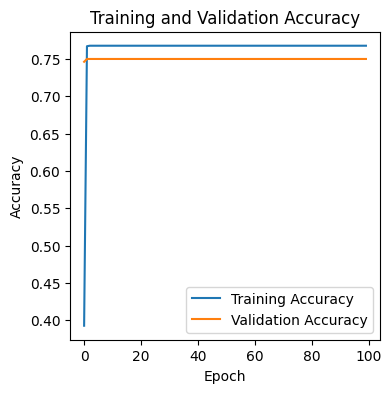

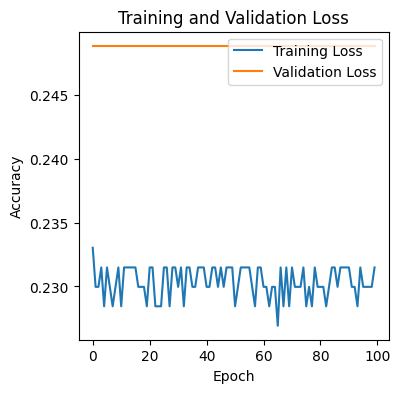

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.show()

plt.figure(figsize=(4, 4))
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Loss')
plt.show()

In [24]:
test_text_input, test_audio_input, test_visual_input, test_labels = prepare_data('test')
test_dataset = [test_text_input, test_audio_input, test_visual_input]

print(test_labels.shape)

print("Evaluate on test data")
results = model.evaluate(test_dataset, test_labels)
print("test loss, test acc:", results)

(686, 7)
Evaluate on test data
22/22 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - accuracy: 0.7589 - loss: 0.2366
test loss, test acc: [0.23654915392398834, 0.7601000070571899]
